In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

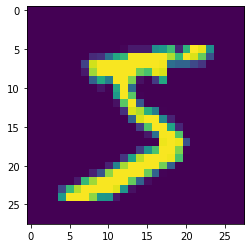

Label of this image: 5


In [15]:
import matplotlib.pyplot as plt

X, y = mnist['data'], mnist['target']

digit = X.iloc[0].to_numpy().reshape(28, 28)

plt.imshow(digit)
plt.show()

print('Label of this image: {}'.format(y.iloc[0]))


In [16]:
y = y.astype(np.uint8)  # Only 10 digits


In [17]:
# MNIST set is already split in test and dataset
X_train, y_train = X.iloc[:60000], y.iloc[:60000]
X_test, y_test = X.iloc[60000:], y.iloc[60000:]

In [18]:
# Some learning models benefit more of shuffled data, others such as time series data (stock prediction)
# rather have the training data in the right order

# MNSIT data set is image recognition and better be shuffled for it's model (and is already shuffled)

In [22]:
# We are going to first do a binary classifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
# We use a Stochastic Gradient Descend classifier, very dependant on randomness, so set the seet to the same

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)  # Will train the data with labels as true/false
                                 # Model will use 28x28 input features

SGDClassifier(random_state=42)

In [26]:
# Predict the first digit we saw (that is a 5)

some_digit = X.iloc[0]

print('Is a 5? {}'.format(sgd_clf.predict([some_digit])))

Is a 5? [ True]


In [39]:
# Measure the accuracy with cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Divides the data in 3 splits while preserving the ratio of sample's labels on each fold
skfolds = StratifiedKFold(n_splits=3) 

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train.iloc[train_index]
    
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_test_fold == y_pred)
    print(n_correct/len(y_pred))
    




0.8787
0.8495
0.85815


In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
print(scores)

[0.95035 0.96035 0.9604 ]


In [41]:
# The score is high, but so is the number of entries that are NOT 5

# The accurracy is often not the best way to measure the classifier performance
from sklearn.model_selection import cross_val_predict

# We are going to use a confusion matrix to measure the score

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)  # Just like cross_val_score, but returns
                                                                     # the predictions instead of the score

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)  
# first row are non-5, a perfect classifier would have 0 on all non-diagonals

array([[53892,   687],
       [ 1891,  3530]])

In [43]:
# precision = true_positive / (true_positive + false_positive)
# recall = true_positive / (true_positive + false_negative)
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred))
recall = recall_score(y_train_5, y_train_pred))
print(precision, recall)

0.8370879772350012
0.6511713705958311


In [44]:
# harmonic_mean = 2 / (1/precision + 1/recall)

from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print(f1)

0.7325171197343846


In [47]:
# the f1 score is not always the best measure either
# For a kid safe video classifier, you want to be as safe as possible (high precision)
# even if it costs to deny some good videos (low recall)

# A shoplifter detection algorithm will still be good with a low precision and high recall

# There is always a trade-off between precision and recall to make

from sklearn.metrics import precision_recall_curve

# Computes the curve of precision/recalls with the threshold value

# Just liek cross_val_predict, but returns the decisions value (that will be thresholded for classification)
# instead of the classification performance score
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

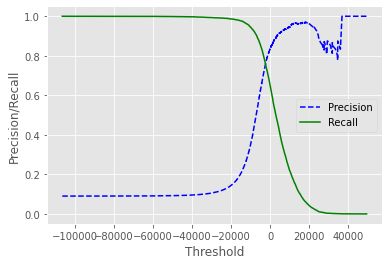

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.style.use('ggplot')

def plot_precision_recalls_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    plt.plot()
    
plot_precision_recalls_vs_threshold(precisions, recalls, thresholds)



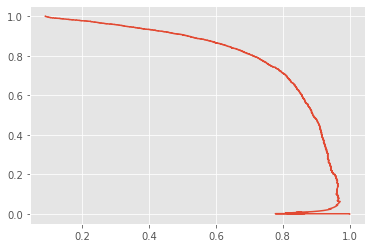

In [51]:
plt.plot(precisions[:-1], recalls[:-1])
plt.show()

In [53]:
# A good way to find a trade-off is through this plot above

# For example, we want to find the threshold that gives 90% of precision

threshold_90_precision = thresholds[np.argmax(precisions >= .9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision = precision_score(y_train_5, y_train_pred_90)
recall = recall_score(y_train_5, y_train_pred_90)

print(precision, recall)

0.9000345901072293 0.4799852425751706


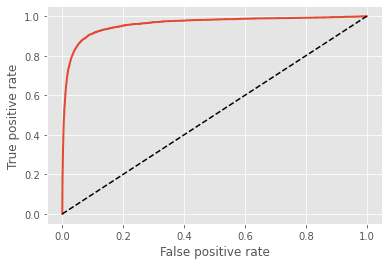

In [54]:
# Another way to measure the binary classifier performance and tune it's decision function
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False positive rate (Recall)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [55]:
# A good classifier would be as far as possible from the diagonal
# The diagonal represents the ROC curve of a totally random classifier
# A good way to evaluate the performance of a model is to compute the area under the curve (AUC)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [56]:
# The score is high but this is due to the fact that there are few positives (few 5) compared to negatives

# One should use the PR curve when he cares more about the false positives than the false negatives
# Otherwise, use ROC

In [59]:
# We do the same with the RandomForestClassifier

# Instead of returning the decision_function that will be threhsolded next,
# the RDC returns the probability for each class in the y_proba_forest

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_proba_forest[:, 1]  # Proba for positives

In [ ]:
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'random forest')